In [1]:
import os
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np
import h5py

In [2]:
df = pd.read_csv("Data/MGMT.csv")
df.head()

,files,labels,x,y
0,BraTS2021_00000,1,/data/slow/RSNA_ASNR_MICCAI_BraTS2021_Training...,/data/slow/RSNA_ASNR_MICCAI_BraTS2021_Training...
1,BraTS2021_00002,1,/data/slow/RSNA_ASNR_MICCAI_BraTS2021_Training...,/data/slow/RSNA_ASNR_MICCAI_BraTS2021_Training...
2,BraTS2021_00003,0,/data/slow/RSNA_ASNR_MICCAI_BraTS2021_Training...,/data/slow/RSNA_ASNR_MICCAI_BraTS2021_Training...
3,BraTS2021_00005,1,/data/slow/RSNA_ASNR_MICCAI_BraTS2021_Training...,/data/slow/RSNA_ASNR_MICCAI_BraTS2021_Training...
4,BraTS2021_00006,1,/data/slow/RSNA_ASNR_MICCAI_BraTS2021_Training...,/data/slow/RSNA_ASNR_MICCAI_BraTS2021_Training...


# Save data slices

In [3]:
files = list(df["files"].values)

In [4]:
def save(path, data):
    
    if "x" in path.split("/"):
        file_type = np.float32
    
    else:
        file_type = np.uint8
    
    with h5py.File(path, 'w') as hf:
        hf.create_dataset("Slice",  data=data, chunks=True, dtype=file_type)        

In [5]:
def create_target(target, y):
    
    y_sum = y.sum()
    
    if y_sum == 0:
        return "BACKGROUND"
    
    else:
        if target == 1:
            return "MGMT - YES"
        else:
            return "MGMT - NO"

In [6]:
def get_data(img):
    
    data = img.get_fdata()
    
    for i, aff in enumerate(np.diag(img.affine)[:-1]):
        if aff < 0:
            data = np.flip(data, axis=i)

    return data

In [7]:
patient_ids = []
x_slice_paths = []
y_slice_paths = []
target_list = [] 
slice_pixel_count_list = []
slice_tumor_pixel_count_list = []
slice_list = []

for i, f in enumerate(files):
    
    x = get_data(nib.load(df["x"].values[i]))

    y = get_data(nib.load(df["y"].values[i]))
    
    path = f"Data/Slices/{f}"
    
    if not os.path.exists(path):
    
        os.mkdir(path)

        x_path = f"{path}/x"
        y_path = f"{path}/y"
        
        os.mkdir(x_path)
        os.mkdir(y_path)
        
        for volume_slice in range(155):
            
            patient_ids.append(f)
                                               
            file = f"{x_path}/{volume_slice}.h5"
            save(file, x[:, :, volume_slice])
            slice_ = x[:, :, volume_slice].copy()
            slice_[slice_ > 0] = 1
            slice_[slice_ < 1] = 0
                        
            slice_sum = slice_.sum()
            
            slice_pixel_count_list.append(slice_sum)
            
            slice_list.append(volume_slice)
            
            x_slice_paths.append(file)
            
            file = f"{y_path}/{volume_slice}.h5"
            save(file, y[:, :, volume_slice])
            slice_ = y[:, :, volume_slice].copy()
            slice_[slice_ > 0] = 1
            slice_[slice_ < 1] = 0
            slice_sum = slice_.sum()
            
            slice_tumor_pixel_count_list.append(slice_sum)
            
            y_slice_paths.append(file)
            
            target = create_target(df["labels"].values[i], y[:, :, volume_slice])
            target_list.append(target)        
        
df_saved = pd.DataFrame(data={
    "patient_id": patient_ids,
    "x": x_slice_paths,
    "y": y_slice_paths,
    "target": target_list,
    "slice_pixel_count": slice_pixel_count_list,
    "slice_tumor_pixel_count": slice_tumor_pixel_count_list,
    "slice": slice_list
})

df_saved.to_csv("Data/MGMT_2D_SLICES.csv", index=False)

In [8]:
x[:, :, volume_slice].sum()

0.0

In [9]:
slice_.shape

(240, 240)

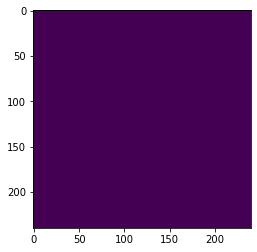

In [10]:
plt.imshow(slice_)

In [11]:
df_saved.head()

,patient_id,x,y,target,slice_pixel_count,slice_tumor_pixel_count,slice
0,BraTS2021_00000,Data/Slices/BraTS2021_00000/x/0.h5,Data/Slices/BraTS2021_00000/y/0.h5,BACKGROUND,0.0,0.0,0
1,BraTS2021_00000,Data/Slices/BraTS2021_00000/x/1.h5,Data/Slices/BraTS2021_00000/y/1.h5,BACKGROUND,0.0,0.0,1
2,BraTS2021_00000,Data/Slices/BraTS2021_00000/x/2.h5,Data/Slices/BraTS2021_00000/y/2.h5,BACKGROUND,0.0,0.0,2
3,BraTS2021_00000,Data/Slices/BraTS2021_00000/x/3.h5,Data/Slices/BraTS2021_00000/y/3.h5,BACKGROUND,0.0,0.0,3
4,BraTS2021_00000,Data/Slices/BraTS2021_00000/x/4.h5,Data/Slices/BraTS2021_00000/y/4.h5,BACKGROUND,6.0,0.0,4


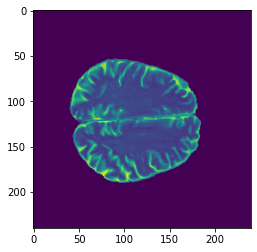

In [12]:
with h5py.File('Data/Slices/BraTS2021_01010/x/100.h5', "r") as f:
    a_group_key = list(f.keys())[0]
    x = np.array(list(f[a_group_key]))

plt.imshow(x)    
plt.show()

In [18]:
df_saved.query("slice == 0").head()

,patient_id,x,y,target,slice_pixel_count,slice_tumor_pixel_count,slice
0,BraTS2021_00000,Data/Slices/BraTS2021_00000/x/0.h5,Data/Slices/BraTS2021_00000/y/0.h5,BACKGROUND,0.0,0.0,0
155,BraTS2021_00002,Data/Slices/BraTS2021_00002/x/0.h5,Data/Slices/BraTS2021_00002/y/0.h5,BACKGROUND,0.0,0.0,0
310,BraTS2021_00003,Data/Slices/BraTS2021_00003/x/0.h5,Data/Slices/BraTS2021_00003/y/0.h5,BACKGROUND,31.0,0.0,0
465,BraTS2021_00005,Data/Slices/BraTS2021_00005/x/0.h5,Data/Slices/BraTS2021_00005/y/0.h5,BACKGROUND,0.0,0.0,0
620,BraTS2021_00006,Data/Slices/BraTS2021_00006/x/0.h5,Data/Slices/BraTS2021_00006/y/0.h5,BACKGROUND,2343.0,0.0,0


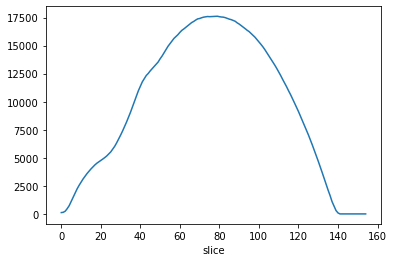

In [14]:
df_saved.groupby("slice")["slice_pixel_count"].median().plot()

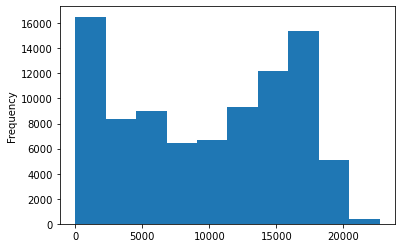

In [15]:
df_saved["slice_pixel_count"].plot.hist()

## Class balance

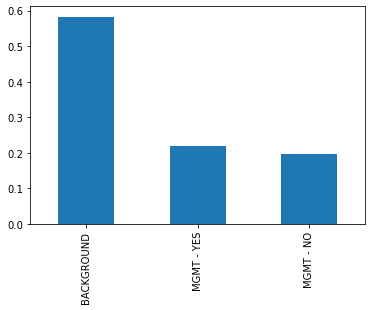

In [16]:
df_saved["target"].value_counts(normalize=True).plot.bar()
plt.show()

# View sample

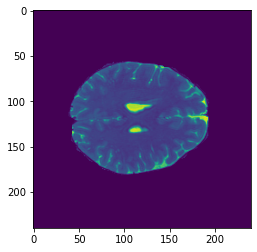

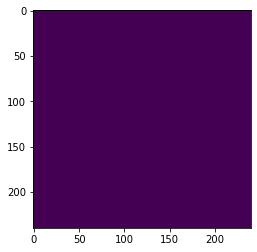

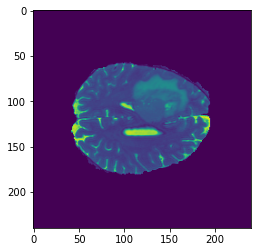

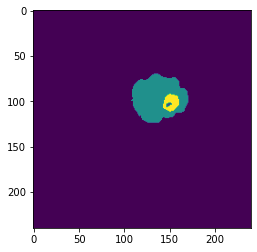

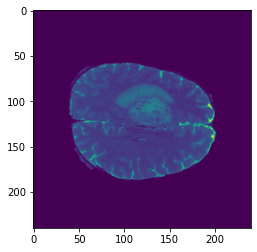

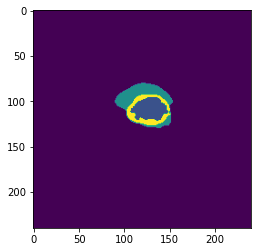

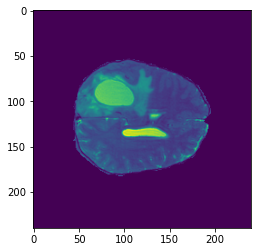

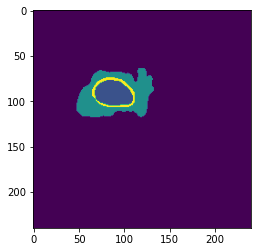

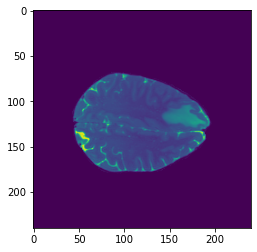

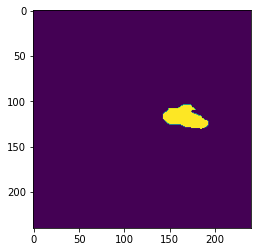

In [17]:
for file in files[0:5]:

    with h5py.File(f'Data/Slices/{file}/x/100.h5', "r") as f:
        a_group_key = list(f.keys())[0]
        x = np.array(list(f[a_group_key]))

    plt.imshow(x)    
    plt.show()

    with h5py.File(f'Data/Slices/{file}/y/100.h5', "r") as f:
        a_group_key = list(f.keys())[0]
        x = np.array(list(f[a_group_key]))

    plt.imshow(x)    
    plt.show()